## Example generator for cell volumes

The variety of tissue stains and cell assemblies makes it difficult to generate a single easy to use simulator for generating test data for image segmentation. Here we present a first attempt of documenting a forward model for the generation of microscopy-like images.

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
from skimage.filters import gaussian, sobel
from skimage.morphology import binary_erosion, ball, erosion
import math

param = {
    'dims': (128, 128, 50), # but tile size is actually twice as big due to zoom
    'numCells': 35,
    'maxCellSize': 100,
    'nucleusSize': 7,
    'cellWallThickness': 2,
    'smoothingKernel': (2,2,3),
    'additiveNoiseStd': 5,
}

Create a random volume with known labels to simulate localized shapes with a wall and a small nucleus inside.

In [2]:
# We distribute cell cores evenly in the volume but we will not get too close to the border (unit is pixel).

def generateCellPointsOfInterest(param):
    fudge = 5
    x_ = np.linspace(0., param['dims'][0]-1., 64)
    y_ = np.linspace(0., param['dims'][1]-1., 64)
    z_ = np.linspace(0., param['dims'][2]-1., 32)
    xg, yg, zg = np.meshgrid(x_, y_, z_, indexing='ij')

    numCells = param['numCells']
    # all cells are space filling, place them randomly, compute the influence region and move to center
    po = []
    for i in range(numCells):
        x = fudge + np.random.rand(1) * (param['dims'][0]-1-fudge)
        y = fudge + np.random.rand(1) * (param['dims'][1]-1.-fudge)
        z = fudge + np.random.rand(1) * (param['dims'][2]-1.-fudge)
        po.append([x.item(),y.item(),z.item()])
    return [xg, yg, zg, po]

def influence(xg,yg,zg,po,param):
    # now compute the influence region
    influence = []
    for i in range(param['numCells']):
        influence.append([])
    xgg = xg.reshape(np.prod(xg.shape), 1)
    ygg = yg.reshape(np.prod(yg.shape), 1)
    zgg = zg.reshape(np.prod(zg.shape), 1)
    # for each voxel coordinate in the volume
    for idx in range(np.prod(xg.shape)):
        x = xgg[idx].item()
        y = ygg[idx].item()
        z = zgg[idx].item()
        minidx = 0
        # this corresponds to the maximum cell radius
        minDist = param['maxCellSize']
        for i in range(param['numCells']):
            x_ = po[i][0]
            y_ = po[i][1]
            z_ = po[i][2]
            d = (x-x_)**2+(y-y_)**2+(z-z_)**2
            if d < minDist:
                minDist = d
                minidx = i
        influence[minidx].append([x, y, z])
    return influence

def centroids(influence):
    cent = []
    for i in range(len(influence)):
        c = [0, 0, 0]
        c[0] = np.mean(np.array(influence[i])[:, 0])
        c[1] = np.mean(np.array(influence[i])[:, 1])
        c[2] = np.mean(np.array(influence[i])[:, 2])
        cent.append(c)
    return cent

# shape is a tupel of dimensions, size is a tupel of voxel sizes
def render2Volume(po, size, shape):
    x_ = np.linspace(0., size[0]*(shape[0]-1), shape[0])
    y_ = np.linspace(0., size[1]*(shape[1]-1), shape[1])
    z_ = np.linspace(0., size[2]*(shape[2]-1), shape[2])
    xg, yg, zg = np.meshgrid(x_, y_, z_, indexing='ij')
    infl = influence(xg,yg,zg,po,param)
    r = np.zeros(shape, dtype=np.int16)
    for i in range(len(infl)):
        for j in range(len(infl[i])):
            x, y, z = infl[i][j]
            r[math.floor(x),math.floor(y),math.floor(z)] = i + 1    
    return r


Use an expectation/maximization algorithm similar to naive k-means to redistribute the initially random locations of the different cells.

In [3]:
[xg, yg, zg, po] = generateCellPointsOfInterest(param)
for i in range(3):
    po2 = centroids(influence(xg,yg,zg,po,param))
    po = po2
#print(po)

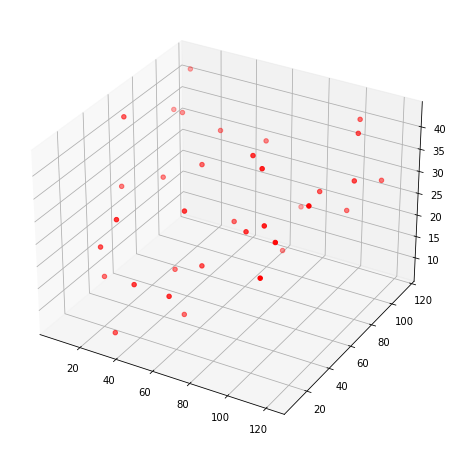

In [4]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter([item[0] for item in po],[item[1] for item in po],[item[2] for item in po],c='r',marker='o')

In [5]:
r = render2Volume(po, [1, 1, 1], [param['dims'][0],param['dims'][1],param['dims'][2]])
# resample to even larger resolution
from scipy.ndimage import zoom
r2 = zoom(r.astype('int16'), (2, 2, 2), order=0, mode='nearest')


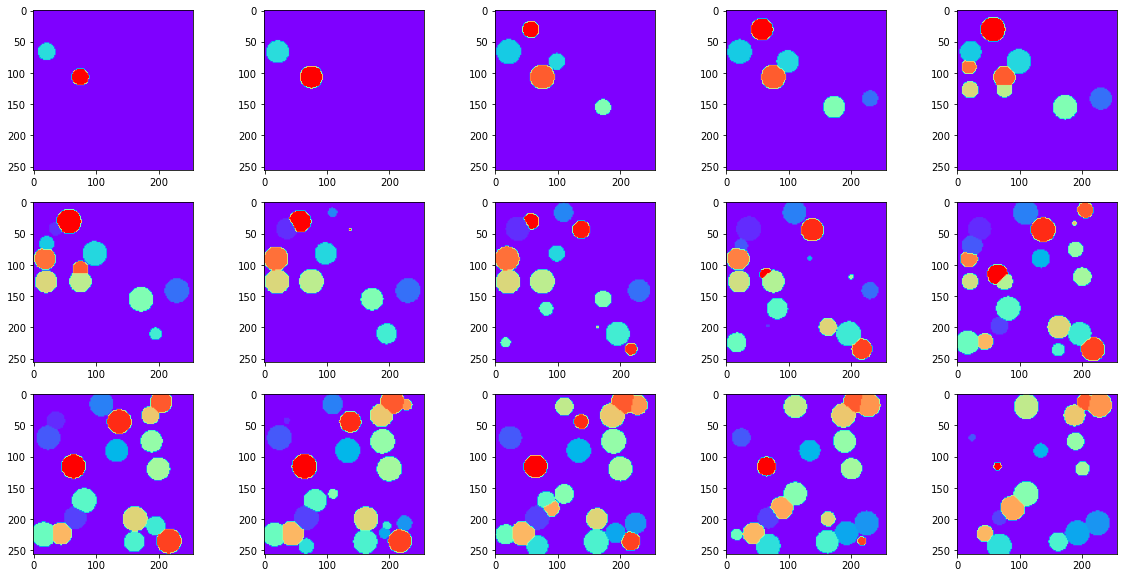

In [6]:

figure = plt.figure(figsize=(20,10))
for i in range(15):
    plt.subplot(3, 5, i+1)
    plt.imshow(r2[:,:,i*math.floor(r2.shape[2]/15)], cmap='rainbow')



Some loops of opening and closing to separate objects to get space for membranes... 

In [7]:
def getCellMasks(r2, param):
    for i in range(param['numCells']):
        extr = np.where(r2 == i+1, 1, 0)
        structuring_element = ball(param['cellWallThickness'], dtype=np.int16)
        extr2 = binary_erosion(extr, selem=structuring_element)
        r3 = np.where(r2 == i+1, 0, r2)
        r3 = r3 + extr2*(i+1)
        r2 = r3
    return r2
cell_masks = getCellMasks(r2, param)


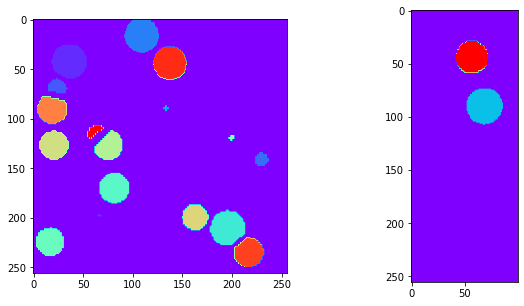

In [8]:
figure = plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.imshow(cell_masks[:,:,50], cmap='rainbow')
plt.subplot(1, 2, 2)
plt.imshow(cell_masks[:,128,:], cmap='rainbow')

Define the cell walls as edges of the cell masks.

In [9]:
cell_walls = sobel(np.where(cell_masks>0, 1, 0))
cell_walls = np.where(cell_walls > 5e-20, 1, 0)

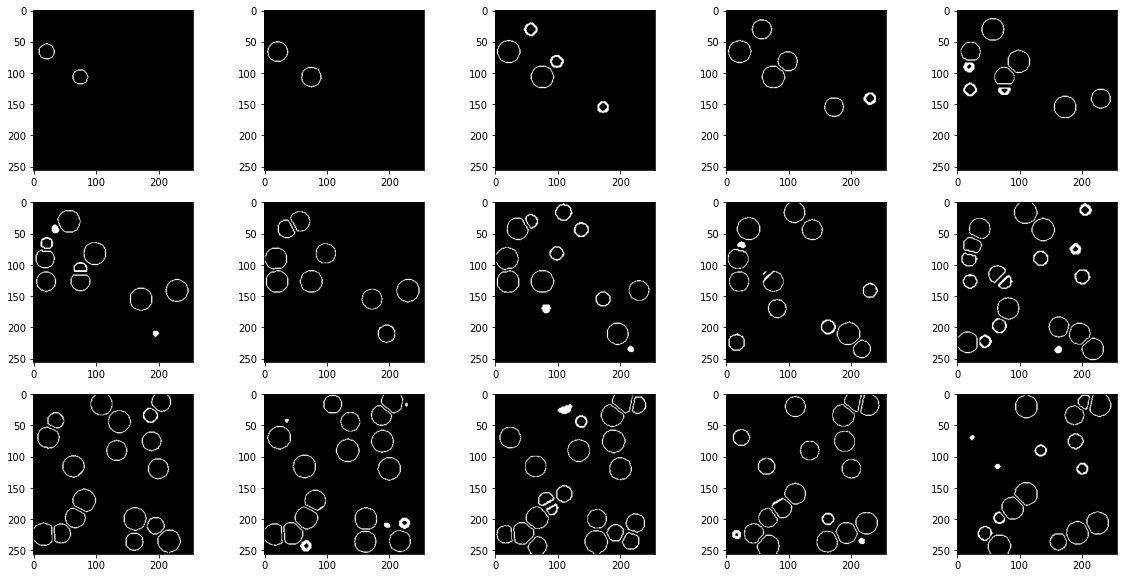

In [10]:
plt.figure(figsize=(20,10))
for i in range(15):
    plt.subplot(3, 5, i+1)
    plt.imshow(cell_walls[:,:,i*math.floor(cell_walls.shape[2]/15)], cmap='gray')


Now as a last step we can add a small circular nucleus to the cell. That is defined by some size. Nuclei might touch the cell walls.

In [11]:
def addSmallNucleii(r2, param):
    nucleus = param['nucleusSize']
    nucleus2 = math.floor(nucleus/2)
    nucleii = np.zeros(cell_masks.shape, dtype=np.int16)
    for i in range(param['numCells']):
        extr = np.where(r2 == i+1, 1, 0)
        structuring_element = ball(nucleus2, dtype=np.int16)
        extr3 = binary_erosion(extr, selem=structuring_element)
        # we also need to remove the border
        extr2 = np.zeros_like(extr3)
        extr2[nucleus2:-nucleus2,nucleus2:-nucleus2,nucleus2:-nucleus2] = extr3[nucleus2:-nucleus2,nucleus2:-nucleus2,nucleus2:-nucleus2]
        # if we have something left, pick a random value inside that mask
        if np.sum(extr2[:]) > 0:
            x, y, z = np.nonzero(extr2)
            idx = np.random.randint(0, len(x))
            x_ = x[idx]-nucleus2
            y_ = y[idx]-nucleus2
            z_ = z[idx]-nucleus2
            center = [x_, y_, z_]
            # copy the structuring element into this location
            nucleii[center[0]:center[0]+nucleus, center[1]:center[1]+nucleus, center[2]:center[2]+nucleus] = structuring_element
    return nucleii
nucleii = addSmallNucleii(r2, param)

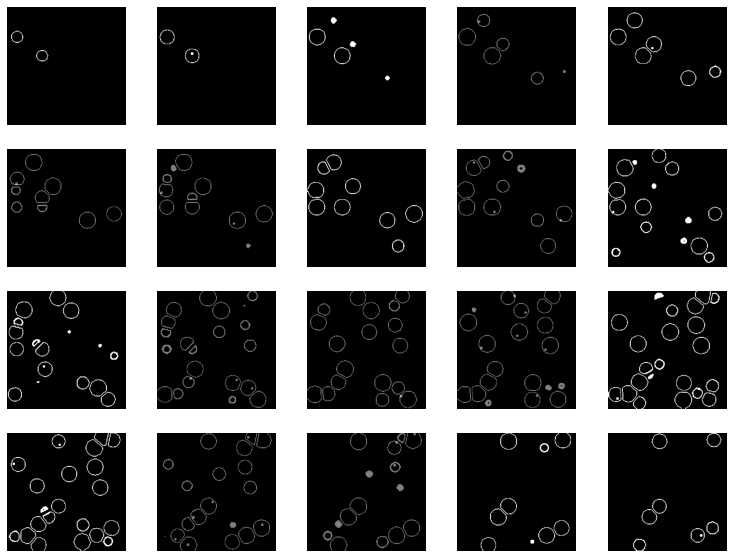

In [12]:
plt.figure(figsize=(13,10))
comb = nucleii + cell_walls
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.imshow(comb[:,:,i*math.floor(comb.shape[2]/20)], cmap='gray')
    plt.axis('off')

As a last step we can simulate the imaging equipment, stain, anisotropic convolume kernel, additive noise etc.. There is lots more that could be done like vinettes, changes in background intensity, spatially varying convolution to simulate out-of-focus problems.

(<matplotlib.image.AxesImage at 0x7f8a77facb20>, (-0.5, 255.5, 255.5, -0.5))

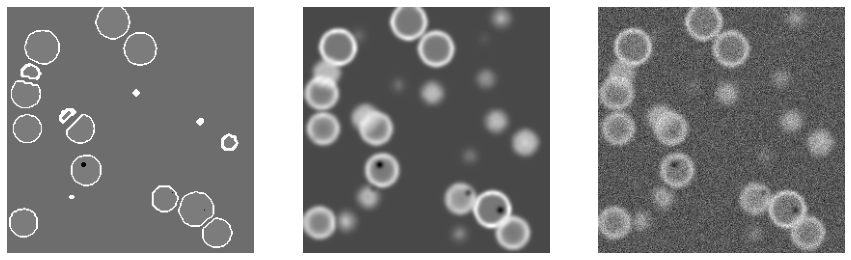

In [15]:
IntensitiesByType = { 'intra-celluar-space': 100, 'nucleus': 40, 'cytoplasm': 108, 'cell-wall': 180 }
# start with the cells
output = cell_masks
output = np.where(output > 0, IntensitiesByType['cytoplasm'], IntensitiesByType['intra-celluar-space'])
output = np.where(cell_walls > 0, IntensitiesByType['cell-wall'], output)
output = np.where(nucleii > 0, IntensitiesByType['nucleus'], output)

figure = plt.figure(figsize=(15,10))
plt.subplot(1, 3, 1)
plt.imshow(output[:,:,math.floor(output.shape[2]/2)], cmap='gray'), plt.axis('off')
label = output

output = gaussian(label, sigma=param['smoothingKernel'], preserve_range=True)
plt.subplot(1, 3, 2)
plt.imshow(output[:,:,math.floor(output.shape[2]/2)], cmap='gray'), plt.axis('off')

output = output + np.random.randn(output.shape[0], output.shape[1], output.shape[2])*param['additiveNoiseStd']
plt.subplot(1, 3, 3)
plt.imshow(output[:,:,math.floor(output.shape[2]/2)], cmap='gray'), plt.axis('off')

The above slice is a single slice from a whole volume of 100 slices. We can use most of these as training data.

Putting it all together we can now create a folder with example data where label image and the corresponding generated image are in two folders. 

In [16]:
from PIL import Image

output_folder = 'data/Train/Microscope'
label_folder = 'data/Train/Label'
if not(os.path.exists(output_folder)):
    os.makedirs(output_folder)
if not(os.path.exists(label_folder)):
    os.makedirs(label_folder)

param = {
    'dims': (128, 128, 50),      # size is actually twice that due to zoom
    'numCells': 35,
    'maxCellSize': 100,          # the square of the radius of the largest cell
    'nucleusSize': 7,
    'cellWallThickness': 2,
    'smoothingKernel': (2,2,3),
    'additiveNoiseStd': 5,
}

for stack in range(20): # 10 stacks of 100 images
    print("Stack: %d" % stack)
    [xg, yg, zg, po] = generateCellPointsOfInterest(param)
    # relax the points of interest
    for i in range(3):
        po2 = centroids(influence(xg,yg,zg,po,param))
        po = po2
    # create a volume and upsample
    r = render2Volume(po, [1, 1, 1], [param['dims'][0],param['dims'][1],param['dims'][2]])
    # resample to even larger resolution
    from scipy.ndimage import zoom
    r2 = zoom(r.astype('int16'), (2, 2, 2), order=0, mode='nearest')
    # create cell masks with some intra-cellular space between cells
    cell_masks = getCellMasks(r2, param)
    # create the walls
    cell_walls = sobel(np.where(cell_masks>0, 1, 0))
    cell_walls = np.where(cell_walls > 5e-20, 1, 0)

    # add some nucleii
    nucleii = addSmallNucleii(r2, param)
    
    # and do camera and noise
    IntensitiesByType = { 'intra-celluar-space': 100, 'nucleus': 40, 'cytoplasm': 108, 'cell-wall': 180 }
    # start with the cells
    output = cell_masks
    output = np.where(output > 0, IntensitiesByType['cytoplasm'], IntensitiesByType['intra-celluar-space'])
    output = np.where(cell_walls > 0, IntensitiesByType['cell-wall'], output)
    output = np.where(nucleii > 0, IntensitiesByType['nucleus'], output)

    label = output

    output = gaussian(label, sigma=param['smoothingKernel'], preserve_range=True)
    output = output + np.random.randn(output.shape[0], output.shape[1], output.shape[2])*param['additiveNoiseStd']
    # and save all slices to disc
    for slice in range(output.shape[2]):
        s = output[:,:,slice].astype(np.uint8)
        l = label[:,:,slice].astype(np.uint8)
        s = Image.fromarray(s)
        s = s.convert("RGB")
        l = Image.fromarray(l)
        s.save(os.path.join(output_folder, '%03d_%03d.png' % (stack, slice)))
        l.save(os.path.join(label_folder, '%03d_%03d.png' % (stack, slice)))


Stack: 0
Stack: 1
Stack: 2
Stack: 3
Stack: 4
Stack: 5
Stack: 6
Stack: 7
Stack: 8
Stack: 9
Stack: 10
Stack: 11
Stack: 12
Stack: 13
Stack: 14
Stack: 15
Stack: 16
Stack: 17
Stack: 18
Stack: 19


# Model training using 2D UNet

A simple model to learn the assignment of tissue types from noisy input data. The following code is based on: https://docs.fast.ai/tutorial.vision.html.

In [17]:
from fastai.vision.all import *
import fastai
import torch
import os, glob
from pathlib import Path

fastai.device = torch.device('cpu')

path = Path('data/Train')
data_path = 'data/Train/Microscope/'
label_path = 'data/Train/Label/'

def label_func(fn):
    return path/"Label"/f"{fn.stem}{fn.suffix}"
codes = ["" for i in range(255)]
for key in IntensitiesByType:
    codes[IntensitiesByType[key]] = key


/usr/local/anaconda3/envs/generateCellVolumes/lib/python3.8/site-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


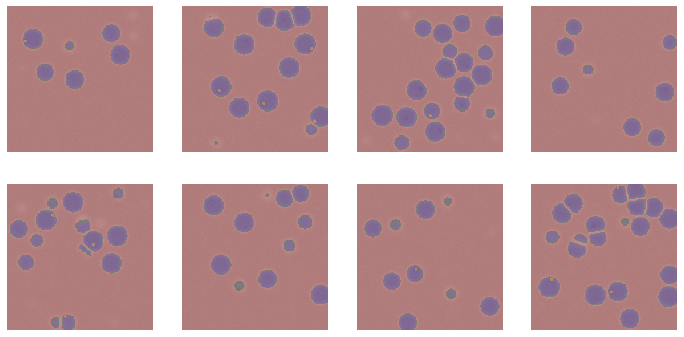

In [18]:
fnames = get_image_files(data_path)
dls = SegmentationDataLoaders.from_label_func(path, bs=16, fnames=fnames, label_func=label_func, num_workers=0, codes=codes)
dls.show_batch(max_n=8)

In [19]:
learn = unet_learner(dls, resnet34, normalize=False)
learn.summary()

DynamicUnet (Input shape: 16 x 3 x 256 x 256)
Layer (type)         Output Shape         Param #    Trainable 
                     16 x 64 x 128 x 128 
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     16 x 64 x 64 x 64   
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                     

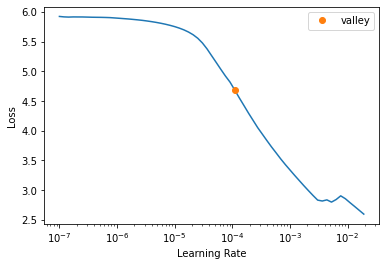

In [17]:
lr_min = learn.lr_find()
# learn.show_results(max_n=6, figsize=(7,8))

In [18]:
lr_min

SuggestedLRs(valley=0.00010964782268274575)

In [20]:
lr_min = 0.00010964
learn.fit_flat_cos(10, lr_min)

epoch,train_loss,valid_loss,time
0,0.188848,0.076780,2:48:59
1,0.069354,0.044890,2:41:51
2,0.042430,0.034606,2:11:05
3,0.033678,0.030168,2:14:03
4,0.029565,0.027644,2:22:32
5,0.027267,0.029046,2:11:03
6,0.025070,0.025236,2:12:24
7,0.023937,0.023339,2:10:13
8,0.022765,0.024803,2:09:14
9,0.020670,0.022561,2:06:57


Path('data/Train/models/model_10.pth')

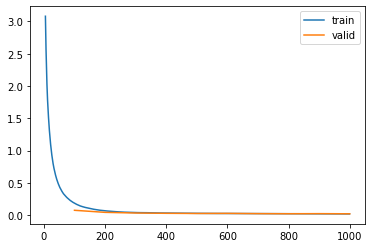

In [21]:
learn.recorder.plot_loss()
learn.save('model_10')
#learn.load('model_5')

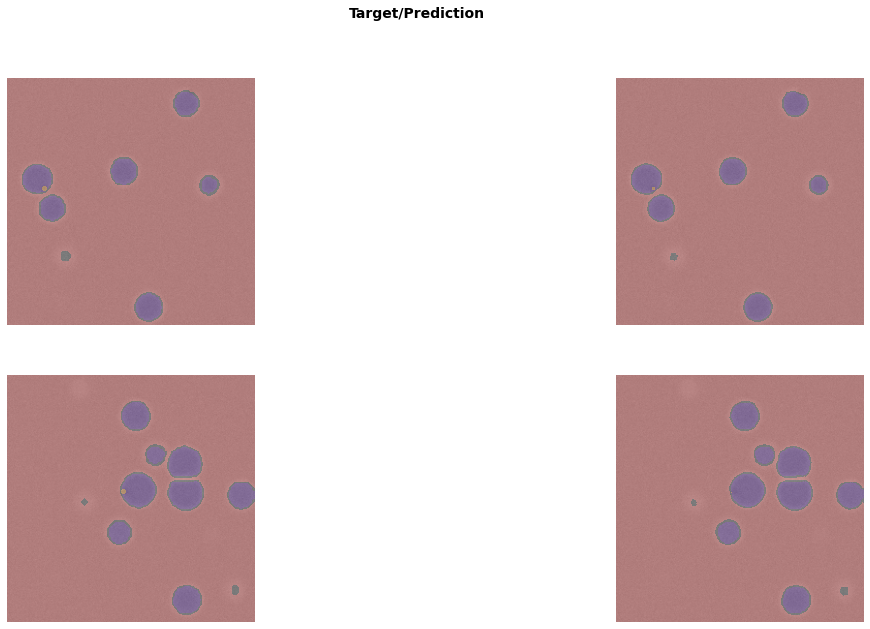

In [24]:
learn.predict(fnames[0])
learn.show_results(figsize=(20,10), max_n=2)


In [27]:
#interp = Interpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(15,10))